In [5]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path+"\\")
sys.path.insert(1, '/home_local/isduser/Desktop/UE20/UE20_COVID19/data')
sys.path.insert(1, '/home_local/isduser/Desktop/UE20/UE20_COVID19/model')

In [6]:
import load_data as dat
import SIRModelSolver
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import scipy

In [19]:
## Import the data
df = dat.load_csse_data()
df

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  \
35         0        0        0        0        0        0        0        0   
36         0        0        0        0        0        0        1        1   
37         0        0        0        0        0        0        0        0   
38         0        0        0        0        0        0        0        0   
39         0        0        0        0        0        0        0        0   
40         0        0        0        0        0        0        0        0   
41         0        0        0        0        0        0        0        0   
42         0        0        0        0        1        1        1        1   
43         0        0        0        0        0        0        0        0   
44         0        0        0        0        0        0        0        0   
45         0        0        0        0        0        0        0        0   
231        0        0        0        0        0    

/home_local/isduser/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,t,I,D
0,0,0,0
1,1,0,0
2,2,0,0
3,3,0,0
4,4,1,0
...,...,...,...
144,144,100404,8218
145,145,100763,8228
146,146,101087,8271
147,147,101491,8312


# Partie SIR

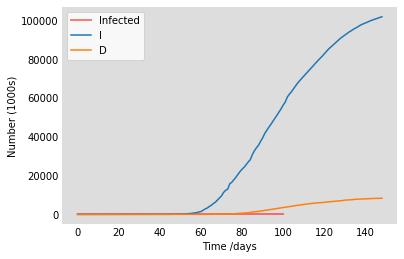

In [8]:
## Total population
N = 37_262_000
## Initial number of infected
I0 = 1
## Initial number of recoveries
R0 = 0
## Initial number of susceptibles people
S0 = N - I0 - R0
## Number of people infected by one diseased person
β = 2
## Recovery rate
γ = 2
## A grid of time points (in days)
t = np.linspace(0, 100)
## Initial conditions vector
y0 = S0, I0, R0

sir = SIRModelSolver.SIRModelSolver(β, γ, I0, R0, N)
S, I, R = odeint(sir.deriv, y0, t, args=(N, β, γ)).T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
    
df[['I','D']].plot(ax=ax)

plt.show()

In [10]:
t2 = range(149)
sir2 = SIRModelSolver.SIRModelSolver(β, γ, R0, I0, N)
sir2.fit(t2, df['I'])

/home_local/isduser/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home_local/isduser/Desktop/UE20/UE20_COVID19/model/SIRModelSolver.py:33: RuntimeWarning: overflow encountered in double_scalars
  dSdt = -β * S * I / N
/home_local/isduser/Desktop/UE20/UE20_COVID19/model/SIRModelSolver.py:34: RuntimeWarning: overflow encountered in double_scalars
  dIdt = β * S * I / N - γ * I
/home_local/isduser/Desktop/UE20/UE20_COVID19/model/SIRModelSolver.py:35: RuntimeWarning: overflow encountered in double_scalars
  dRdt = γ * I


[β,γ] = [[1.30183964 1.20095968]], Barres d'erreur = [[[0.00033782 0.00033725]
 [0.00033725 0.00033708]]]


# Partie SEIR

In [11]:
import SEIRModelSolver

In [12]:
## Total population
N = 37_262_000
## Initial number of exposed people 
E0 = 1
## Initial number of infected
I0 = 1
## Initial number of recoveries
R0 = 0
## Number of people infected by one diseased person
β = 2
## Incubation rate of the virus
σ = 14
## Recovery rate
γ = 2

seir = SEIRModelSolver.SEIRModelSolver(β, σ, γ, E0, I0, R0, N)
t = range(149)
seir.fit(t, df['I']-df['D'])

/home_local/isduser/Desktop/UE20/UE20_COVID19/model/SEIRModelSolver.py:38: RuntimeWarning: overflow encountered in double_scalars
  dEdt = β * S * I/N - (σ * E)
/home_local/isduser/Desktop/UE20/UE20_COVID19/model/SEIRModelSolver.py:39: RuntimeWarning: overflow encountered in double_scalars
  dIdt = σ * E - γ * I


[β,σ,γ] = [[1.76881564 1.82148449 1.57599431]], Barres d'erreur = [[[0.00017555 0.00038698 0.00019886]
 [0.00038698 0.00261502 0.00052055]
 [0.00019886 0.00052055 0.00023067]]]


# Partie SEIRD

In [14]:
import SEIRDModelSolver

In [15]:
## Total population
N = 37_262_000
## Initial number of exposed people 
E0 = 1
## Initial number of infected
I0 = 1
## Initial number of recoveries
R0 = 0
## Initial nmber of deaths
D0 = 0
## Number of people infected by one diseased person
β = 2
## Incubation rate of the virus
σ = 5
## Recovery rate
γ = 2
## Mortality rate due to the disease
µ = 0.03

seird = SEIRDModelSolver.SEIRDModelSolver(β, σ, γ, µ, E0, I0, R0, D0, N)
t = range(149)
seird.fit(t, df['I'])

[β,σ,γ,µ] = [[1. 1. 1. 1.]], Barres d'erreur = [[[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]]


/home_local/isduser/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


## La partie qui suit n'est pas totallement fonctionnelle

In [ ]:
import SEIRDModelSolver

## Population totale
N = 1_000_000
## Durée de l'infection
D = 14.0
## Nombre de personnes qui recover chaque jour
gamma = 1.0/D
## Temps d'incubation du virus
delta = 1./14.
## Nombre de personnes total qu'une personne infecte
R_0 = 3.
##
beta = R_0 * gamma
## Taux de mortalité
alpha = 0.02
## Nombre de jours avant de mourir d'une infection
rho = 1./7.
## Susceptible / Exposés / Infectés / Recoveré
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0
t = np.linspace(0,99,100)
## Conditions initiales
y0 = S0, E0, I0, R0, D0

seird = SEIRDModelSolver.SEIRDModelSolver(alpha, beta, delta, gamma, rho)

ret = seird._deriv(y0, t, N, alpha, beta, delta, gamma, rho)

plotseird(t, S, E, I, R, D)